In [1]:
import os
import numpy as np
import pandas as pd

import warnings 

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as image
# from matplotlib import transforms

from nilearn import plotting, datasets
import nibabel as nb

In [2]:
resdir = './src_shiny_app/assets/results/'


def detect_models(resdir=resdir):
    allmods = [x[0].split('/')[-1] for x in os.walk(resdir)][1:]  # assume all stored in resdir

    am_clean = list(set([x.split('.')[1] for x in allmods]))  # assume structure lh.name.measure

    out_terms = {}

    for model in sorted(am_clean):
        # Assume you have left and right hemispheres are always run and with the same model
        mdir = f'{resdir}lh.{model}.w_g.pct'
        stacks = pd.read_table(f'{mdir}/stack_names.txt', delimiter="\t")
        
        out_terms[model] = dict(zip(list(stacks.stack_name)[1:], list(stacks.stack_number)[1:]))
    
    return out_terms

models = detect_models()

In [3]:
def extract_results(model, term, thr='30'):

    stack = models[model][term]

    min_beta = []
    max_beta = []
    med_beta = []
    n_clusters = []

    sign_clusters_left_right = {}
    sign_betas_left_right = {}

    for hemi in ['left', 'right']:
        mdir = f'{resdir}{hemi[0]}h.{model}.w_g.pct'
        
        # Read significant cluster map
        ocn = nb.load(f'{mdir}/stack{stack}.cache.th{thr}.abs.sig.ocn.mgh')
        sign_clusters = np.array(ocn.dataobj).flatten()

        if not np.any(sign_clusters):  # all zeros = no significant clusters
            betas = np.empty(sign_clusters.shape)
            betas.fill(np.nan)
            n_clusters.append(0)
        else:
            # Read beta map
            coef = nb.load(f'{mdir}/stack{stack}.coef.mgh')
            betas = np.array(coef.dataobj).flatten()

            # Set non-significant betas to NA
            mask = np.where(sign_clusters == 0)[0]
            betas[mask] = np.nan

            n_clusters.append(np.max(sign_clusters))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            min_beta.append(np.nanmin(betas))
            max_beta.append(np.nanmax(betas))
            med_beta.append(np.nanmean(betas))

        sign_clusters_left_right[hemi] = sign_clusters
        sign_betas_left_right[hemi] = betas

    return np.nanmin(min_beta), np.nanmax(max_beta), np.nanmean(med_beta), n_clusters, \
           sign_clusters_left_right, sign_betas_left_right

In [4]:
def fetch_surface(resolution):
    # Size / number of nodes per map
    n_nodes = {'fsaverage': 163842,
               'fsaverage6': 40962,
               'fsaverage5': 10242}

    return datasets.fetch_surf_fsaverage(mesh=resolution), n_nodes[resolution]


## Figure 2

In [5]:
def make_fig(matrix, size=10):
    fig, axs = plt.subplot_mosaic(matrix, subplot_kw={'projection': '3d'},
                                  gridspec_kw=dict(wspace=0, hspace=0),
                                  figsize=(size,size))
    return fig, axs

# fig, axs = plt.subplot_mosaic([
#   ['lateral_left','lateral_right','dorsal_left',  '.', 'anterior_left', 'anterior_right','cmap'],
#   ['lateral_left','lateral_right','dorsal_right', '.', 'anterior_left', 'anterior_right','cmap'],
#   ['.','.','.','.','.','.','cmap'],
#   ['medial_left', 'medial_right', 'ventral_left', '.', 'posterior_left','posterior_right','cmap'],
#   ['medial_left', 'medial_right', 'ventral_right','.', 'posterior_left','posterior_right','cmap']],
                          
#                             per_subplot_kw={'lateral_left': {'projection': '3d'}, 
#                                             'lateral_right': {'projection': '3d'}, 
#                                             'dorsal_left': {'projection': '3d'}, 
#                                             'dorsal_right': {'projection': '3d'},
#                                             'anterior_left': {'projection': '3d'}, 
#                                             'anterior_right': {'projection': '3d'},
#                                             'medial_left': {'projection': '3d'}, 
#                                             'medial_right': {'projection': '3d'},
#                                             'ventral_left': {'projection': '3d'}, 
#                                             'ventral_right': {'projection': '3d'},
#                                             'posterior_left': {'projection': '3d'}, 
#                                             'posterior_right': {'projection': '3d'}},
#                             width_ratios=[200,200,200,1,50,50,10],
#                             height_ratios=[50,50,1,50,50],
#                             gridspec_kw=dict(wspace=0, hspace=0),
#                             # sharex=True, sharey=True,
#                             figsize=(14, 7))
    

In [6]:
def plot_surfmap(model,
                 term,
                 views=['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'],
                 surf='infl',  # 'pial', 'infl', 'flat', 'sphere'
                 resol='fsaverage5',
                 cmap = 'viridis'):
    
    # Figure structure
    fig1, axs1 = make_fig([['lateral_left','lateral_right'],
                           ['medial_left', 'medial_right']]);
    fig2, axs2 = make_fig([['dorsal_left', 'ventral_left'],
                           ['dorsal_right', 'ventral_right']]);
    fig3, axs3 = make_fig([['anterior_right', 'anterior_left'],
                           ['posterior_left', 'posterior_right']]);

    # Extract results
    min_beta, max_beta, mean_beta, n_clusters, sign_clusters, sign_betas = extract_results(model, term)
    fs_avg, n_nodes = fetch_surface(resol)
    
    for hemi in ['left', 'right']:
        
        stats_map = sign_betas[hemi]
        stats_map[np.isnan(stats_map)] = 0 # colormap throws error otherwise 

        max_val = max_beta
        min_val = min_beta

        if max_val < 0 and min_val < 0:  # all negative associations
            thresh = max_val
        elif max_val > 0 and min_val > 0:  # all positive associations
            thresh = min_val
        else:
            thresh = np.nanmin(abs(stats_map))

        for view in views:

            if view in ['lateral', 'medial']:
                fig, axs = fig1, axs1
            elif view in ['dorsal', 'ventral']:
                fig, axs = fig2, axs2
            else:
                fig, axs = fig3, axs3
            
            p = plotting.plot_surf(
                surf_mesh=fs_avg[f'{surf}_{hemi}'],  # Surface mesh geometry
                surf_map=stats_map[:n_nodes],  # Statistical map
                bg_map=fs_avg[f'sulc_{hemi}'], 
                # alpha=.2,
                # darkness=0.7,
                hemi=hemi,
                view=view,
                engine='matplotlib',
                cmap=cmap,
                symmetric_cmap=False,
                axes= axs[f'{view}_{hemi}'],
                figure=fig,
                colorbar=False,
                vmin=min_val, vmax=max_val,
                cbar_vmin=min_val, cbar_vmax=max_val,
                # avg_method='median',
                threshold=abs(thresh)
            )

            xmin, xmax = axs[f'{view}_{hemi}'].get_xlim()  # same left and right
            ymin, ymax = axs[f'{view}_{hemi}'].get_ylim()  # same left and right
            # print(xmin, xmax)
            
            if view in ['dorsal','ventral','anterior','posterior']:
                shift = 90
                axs[f'{view}_left'].set(xlim=(xmin-shift, xmax-shift))
                axs[f'{view}_right'].set(xlim=(xmin+shift, xmax+shift))
            else:
                shift = 20
                axs[f'lateral_{hemi}'].set(ylim=(ymin+shift, ymax+shift))
                axs[f'medial_{hemi}'].set(ylim=(ymin-shift, ymax-shift))

    fig1.savefig(f'f1_{term[:4]}.png');
    fig2.savefig(f'f2_{term[:4]}.png');
    fig3.savefig(f'f3_{term[:4]}.png');
    
    return min_beta, max_beta

In [7]:
def figure_1(model, term, title):
    minb, maxb = plot_surfmap(model, term)

    # Size and structure 
    w1 = 700; w3 = w2 = 350
    h1 = h3 = 700; h2 = 350
    
    fig, axs = plt.subplot_mosaic([['f1','f2t','f3', 'cbar'],
                                   ['f1','f2b','f3', 'cbar']],
                                   width_ratios=[w1, w2, w3, 80], height_ratios=[h2,h2],
                                   gridspec_kw=dict(wspace=0.1, hspace=0),
                                   figsize=(20,10))

    # F2 (dorsal_ventral) needs to be split in two (fix later)
    im2 = image.imread(f'f2_{term[:4]}.png')[int(500-(h2/2)):int(500+(h2/2)), :, :] # int(500-(w2/2)):int(500+(w2/2))
    buffer = 130
    im2t = im2[:, 0+buffer:w2+buffer, :]
    im2b = im2[:, 1000-w2-buffer:1000-buffer, :]

    # Cut margins and display all figures 
    axs['f1'].imshow(image.imread(f'f1_{term[:4]}.png')[int(500-(h1/2)):int(500+(h1/2)), int(500-(w1/2)):int(500+(w1/2)), :])
    axs['f2t'].imshow(im2t)
    axs['f2b'].imshow(im2b)
    axs['f3'].imshow(image.imread(f'f3_{term[:4]}.png')[int(500-(h3/2)):int(500+(h3/2)), int(500-(w3/2)):int(500+(w3/2)), :])

    # Remove axes 
    axs['f1'].axis('off'); axs['f2t'].axis('off'); axs['f2b'].axis('off'); axs['f3'].axis('off'); 
    
    # Colorbar 
    cb = mpl.colorbar.ColorbarBase(axs['cbar'], 
                                   cmap='viridis', norm=mpl.colors.Normalize(vmin=minb, vmax=maxb),
                                   orientation='vertical', ticklocation='right')
    cb.set_label('Beta value', fontsize=12, fontweight='bold', labelpad=15)
    cb.set_ticks(list(np.arange(0, -0.51, -0.05)), 
                 labels=['{:.2f}'.format(i) for i in list(np.arange(0, -0.51, -0.05))], fontsize=12)
    
    # Text 
    top=0.827; bot=0.44;
    v1=0.305; v2=0.576; v3=0.764
    
    fig.text(v1, top,  'Lateral view',  ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    fig.text(v2, top,  'Dorsal view',   ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    fig.text(v3, top,  'Anterior view', ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    
    fig.text(v1, bot,  'Medial view',   ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    fig.text(v2, bot,  'Ventral view',  ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    fig.text(v3, bot,  'Posterior view',ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    
    l1 = 0.151; r1 = 0.45; p1 = 0.57
    fig.text(l1, p1,  'L',  ha='center', style = 'italic', fontsize = 20, color='grey') 
    fig.text(r1, p1,  'R',  ha='center', style = 'italic', fontsize = 20, color='grey') 
    
    fig.suptitle(title, fontsize=25, fontweight='bold')
    
    # Clean up
    os.remove(f'f1_{term[:4]}.png')
    os.remove(f'f2_{term[:4]}.png')
    os.remove(f'f3_{term[:4]}.png')

    fig.savefig(f'../Figure1_{term[:4]}.png', bbox_inches='tight')
    
    return fig


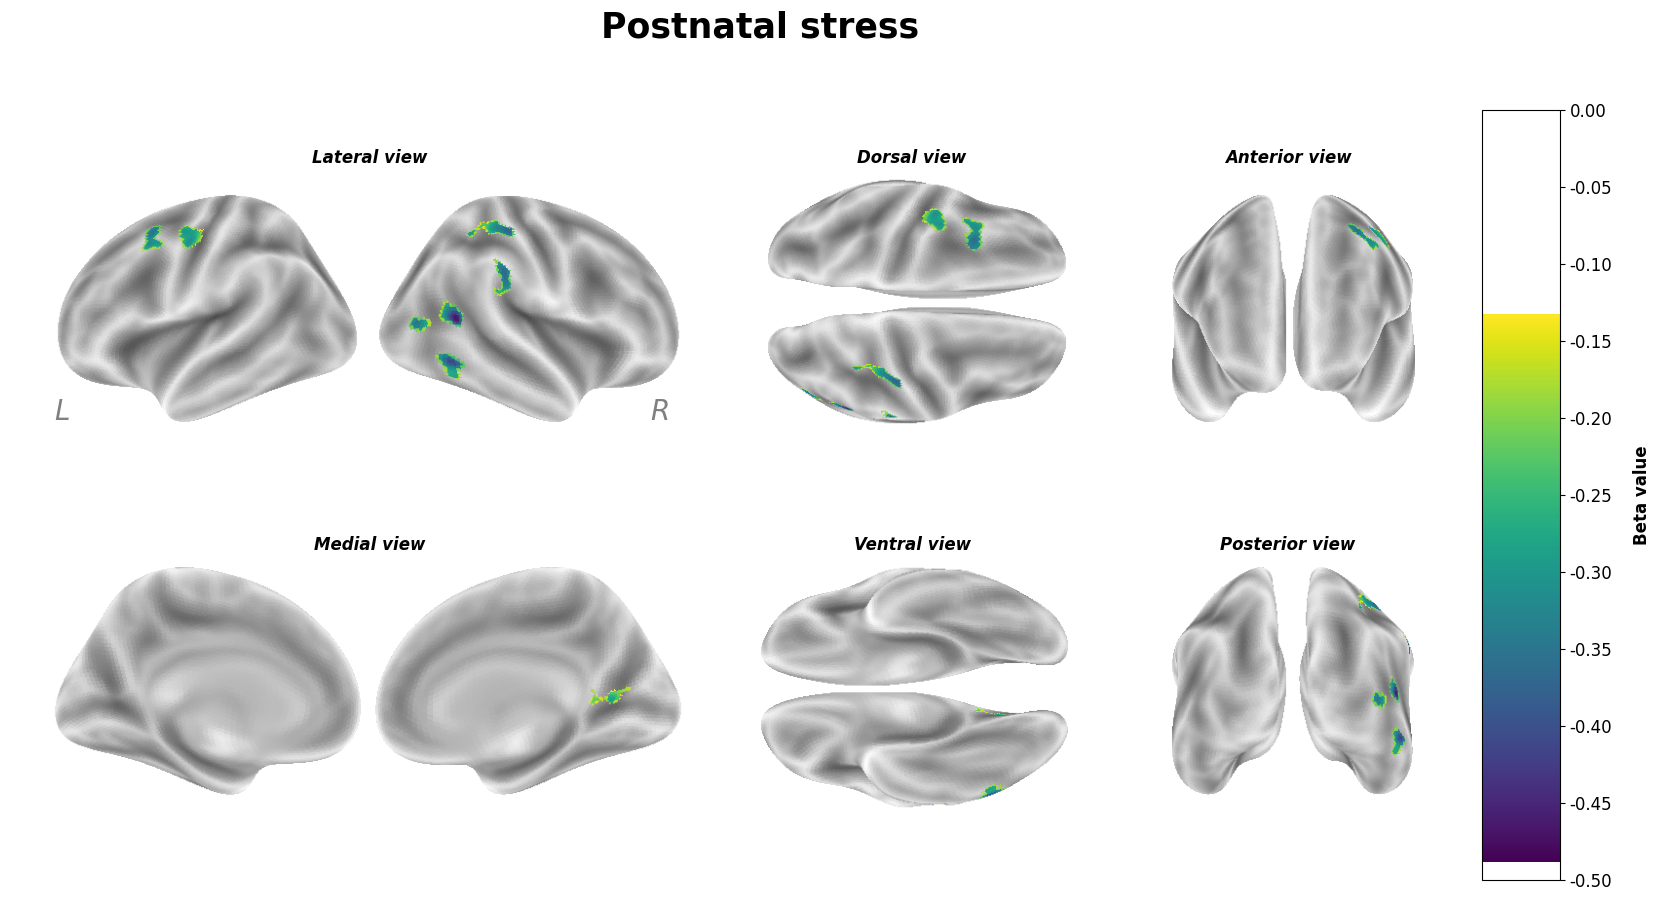

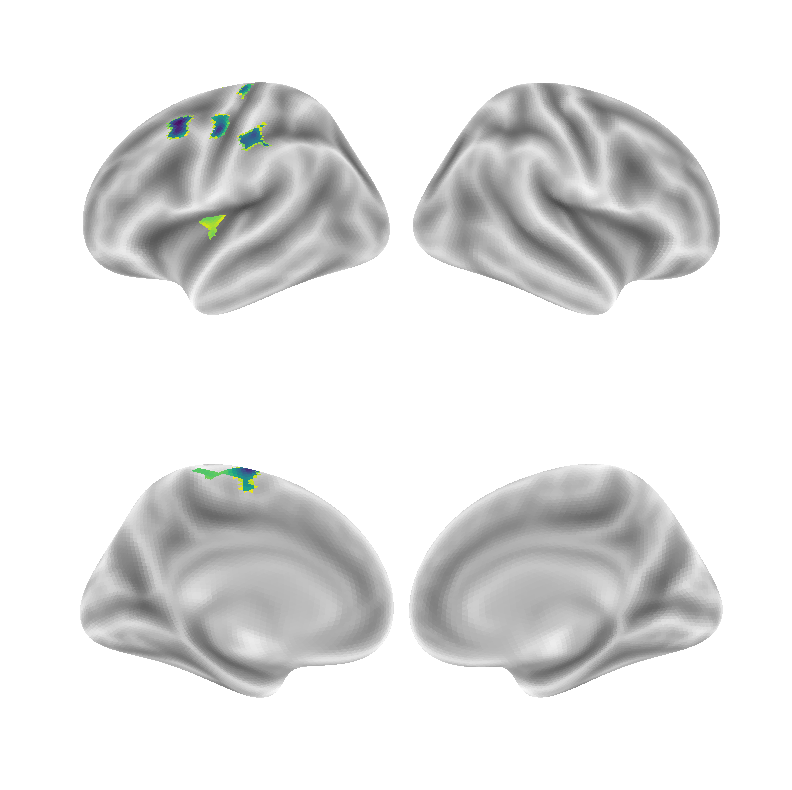

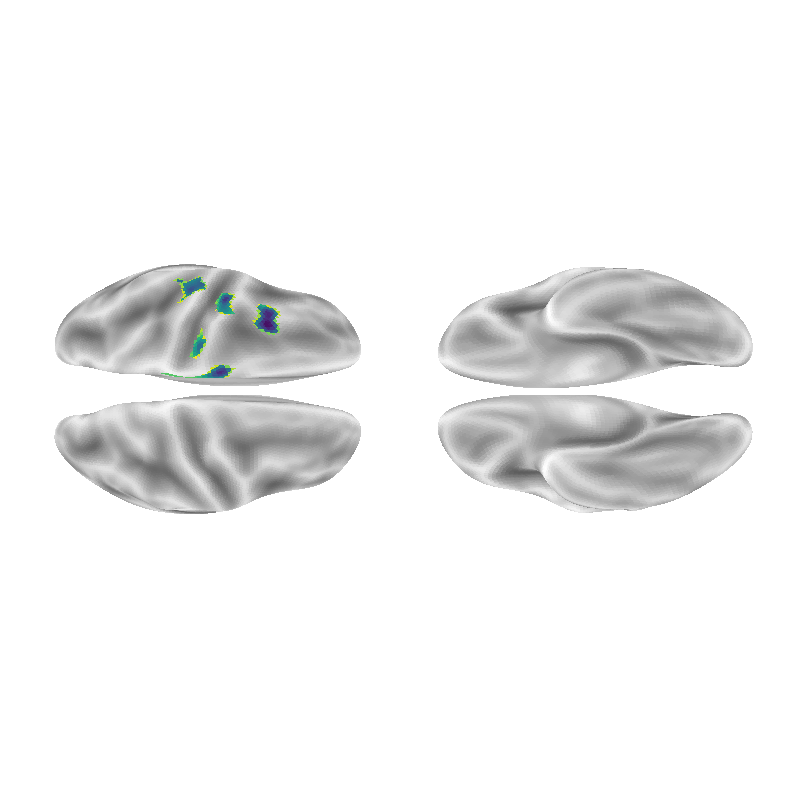

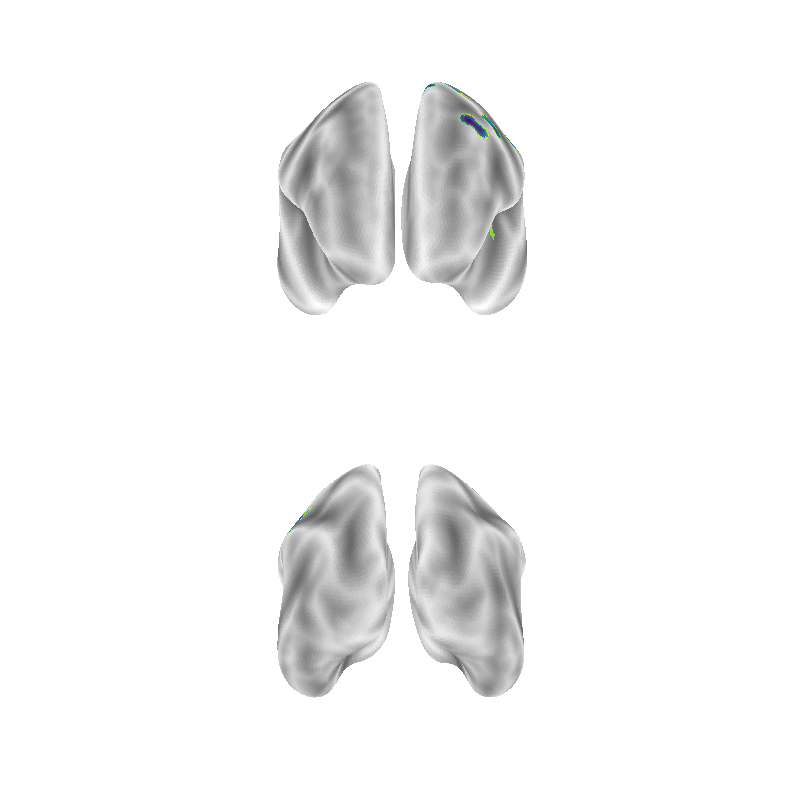

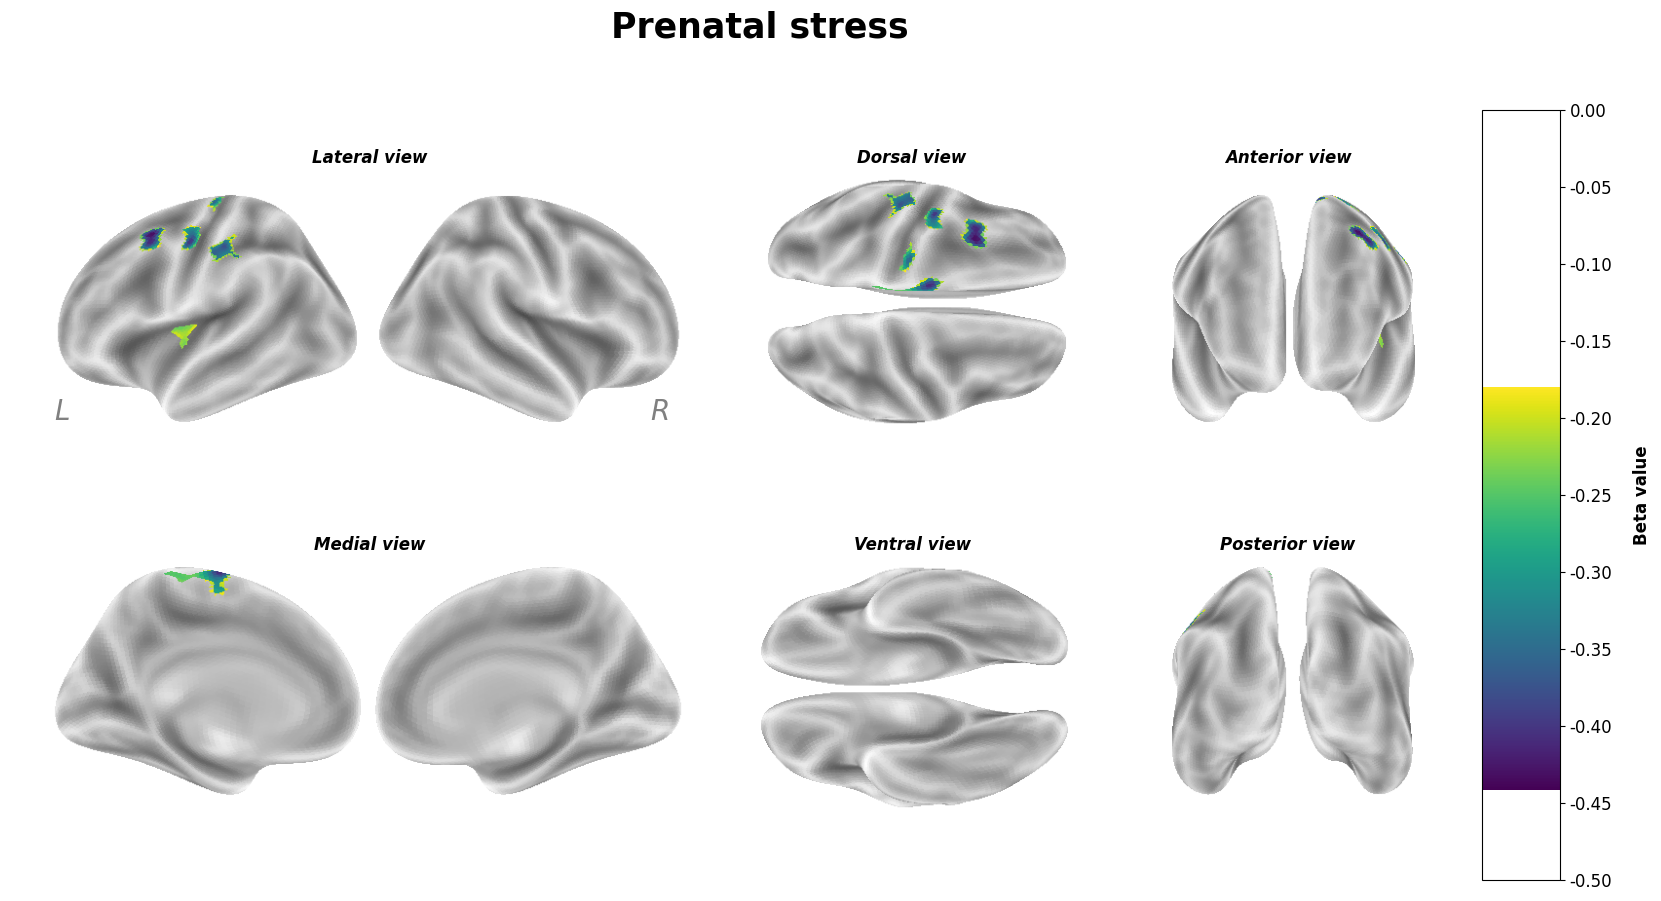

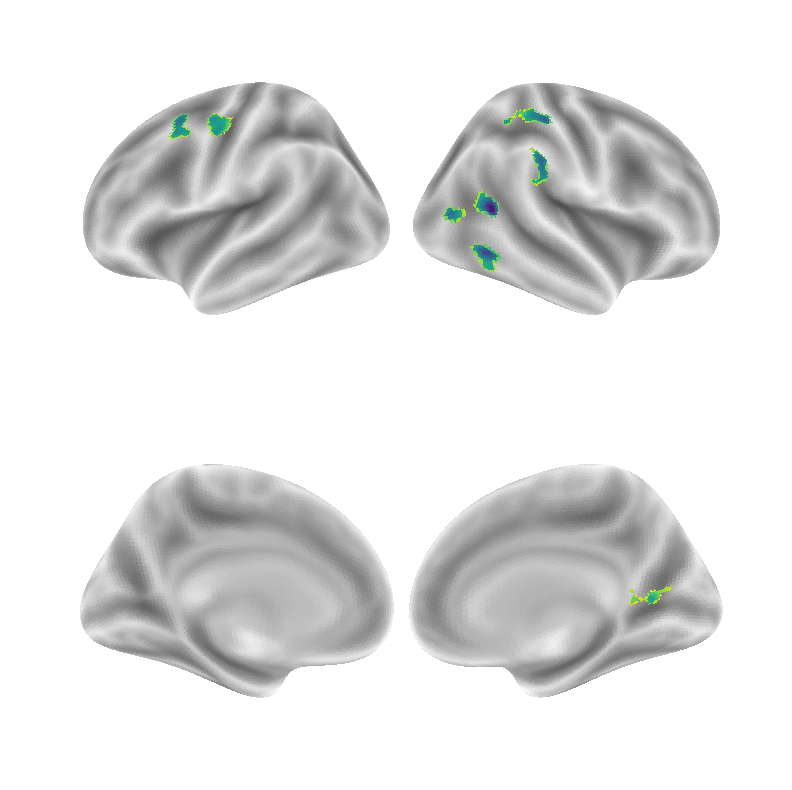

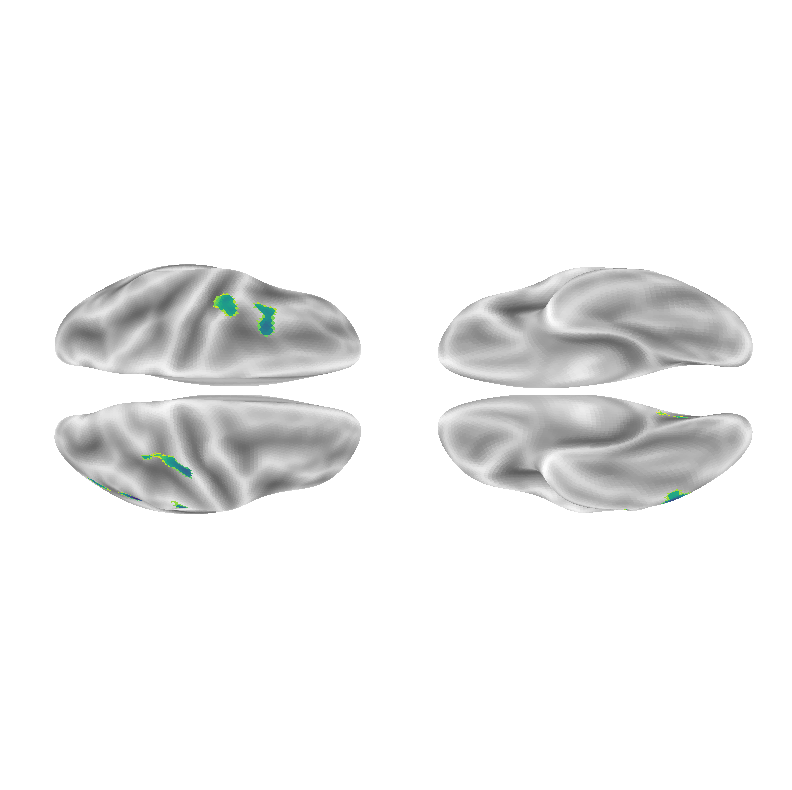

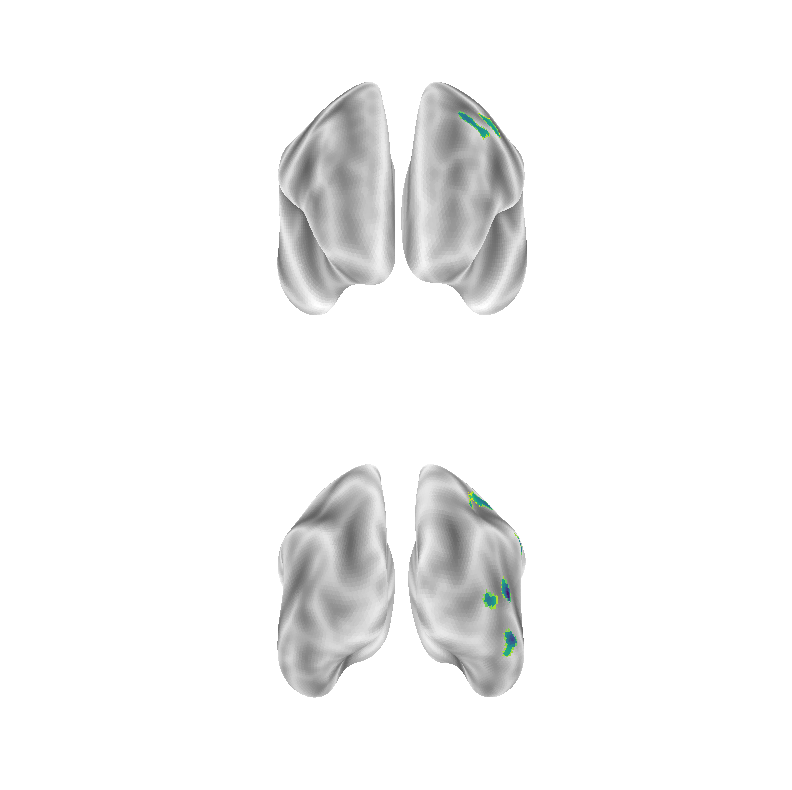

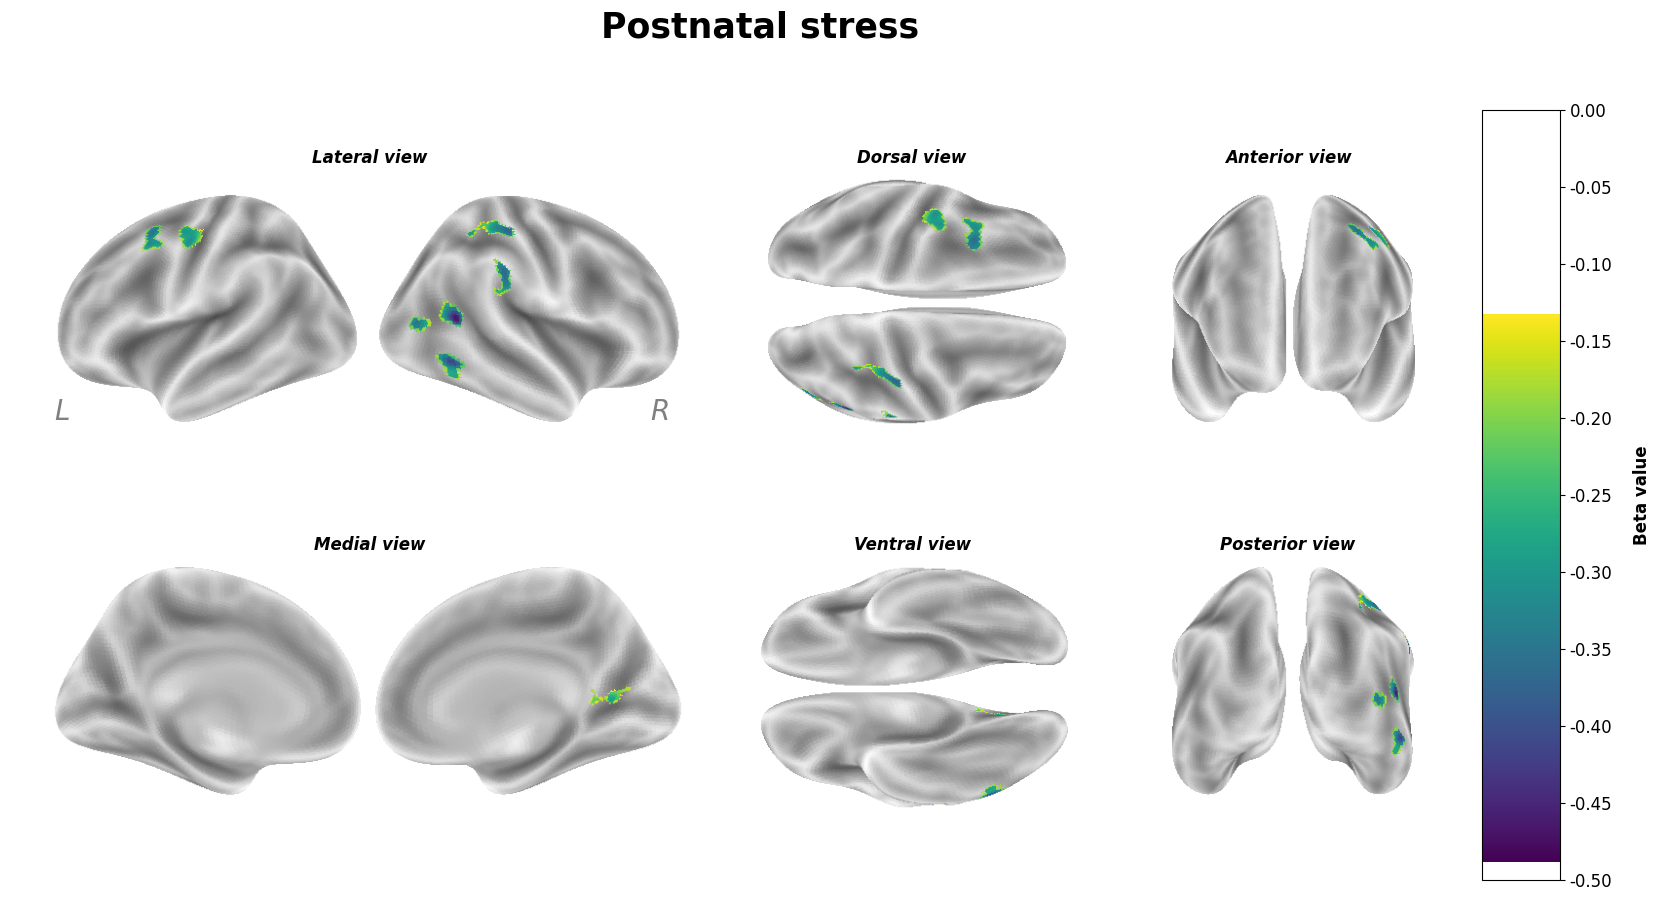

In [8]:
pref1 = figure_1(model='prenatal_stress', term='prenatal_stress_z', title='Prenatal stress')
posf1 = figure_1(model='postnatal_stress', term='postnatal_stress_z', title='Postnatal stress')

## Figure 3

In [9]:
def compute_overlap(model1, term1, model2, term2):

    sign_clusters1 = extract_results(model1, term1)[4]
    sign_clusters2 = extract_results(model2, term2)[4]

    ovlp_maps = {}
    ovlp_info = {}

    for hemi in ['left', 'right']:
        sign1, sign2 = sign_clusters1[hemi], sign_clusters2[hemi]

        sign1[sign1 > 0] = 1
        sign2[sign2 > 0] = 2

        # Create maps
        ovlp_maps[hemi] = np.sum([sign1, sign2], axis=0)

        # Extract info
        uniques, counts = np.unique(ovlp_maps[hemi], return_counts=True)
        ovlp_info[hemi] = dict(zip(uniques, counts))
        ovlp_info[hemi].pop(0)  # only significant clusters

    # Merge left and right info
    info = {k: [ovlp_info['left'].get(k, 0) + ovlp_info['right'].get(k, 0)] for k in
            set(ovlp_info['left']) | set(ovlp_info['right'])}
    percent = [round(i[0] / sum(sum(info.values(), [])) * 100, 1) for i in info.values()]

    for i, k in enumerate(info.keys()):
        info[k].append(percent[i])

    return info, ovlp_maps

# ------------------------------------------------------------------------------------

# ---------------------------------------------------------------------------------------------


def plot_overlap(model1, term1, model2, term2, 
                 views=['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior'],
                 surf='infl', 
                 resol='fsaverage5', 
                 colors=['#88CCEE','#DDCC77','#CC6677']):
    
    # Figure structure
    fig1, axs1 = make_fig([['lateral_left','lateral_right'],
                           ['medial_left', 'medial_right']]);
    fig2, axs2 = make_fig([['dorsal_left', 'ventral_left'],
                           ['dorsal_right', 'ventral_right']]);
    fig3, axs3 = make_fig([['anterior_right', 'anterior_left'],
                           ['posterior_left', 'posterior_right']]);

    # Extract results
    ovlp_maps = compute_overlap(model1, term1, model2, term2)[1]
    fs_avg, n_nodes = fetch_surface(resol)

    cmap = mpl.colors.ListedColormap(colors)

    for hemi in ['left', 'right']:
        for view in views:

            if view in ['lateral', 'medial']:
                fig, axs = fig1, axs1
            elif view in ['dorsal', 'ventral']:
                fig, axs = fig2, axs2
            else:
                fig, axs = fig3, axs3
            
            p = plotting.plot_surf(
                surf_mesh=fs_avg[f'{surf}_{hemi}'],  # Surface mesh geometry
                surf_map=ovlp_maps[hemi][:n_nodes],  # Statistical map
                bg_map=fs_avg[f'sulc_{hemi}'],  
                # alpha=.2,
                # darkness=0.7,
                hemi=hemi,
                view=view,
                engine='matplotlib',
                cmap=cmap,
                symmetric_cmap=False,
                axes= axs[f'{view}_{hemi}'],
                figure=fig,
                colorbar=False,
                vmin=1, vmax=3,
                threshold=1)
        
            xmin, xmax = axs[f'{view}_{hemi}'].get_xlim()  # same left and right
            ymin, ymax = axs[f'{view}_{hemi}'].get_ylim()  # same left and right
            # print(xmin, xmax)
            
            if view in ['dorsal','ventral','anterior','posterior']:
                shift = 90
                axs[f'{view}_left'].set(xlim=(xmin-shift, xmax-shift))
                axs[f'{view}_right'].set(xlim=(xmin+shift, xmax+shift))
            else:
                shift = 20
                axs[f'lateral_{hemi}'].set(ylim=(ymin+shift, ymax+shift))
                axs[f'medial_{hemi}'].set(ylim=(ymin-shift, ymax-shift))

    fig1.savefig(f'f1_ovlp.png');
    fig2.savefig(f'f2_ovlp.png');
    fig3.savefig(f'f3_ovlp.png');
    
    return colors


In [10]:
def figure_2(model1, term1, model2, term2, title='Overlap'):
    
    cols = plot_overlap(model1, term1, model2, term2)

    # Size and structure 
    w1 = 700; w3 = w2 = 350
    h1 = h3 = 700; h2 = 350
    
    fig, axs = plt.subplot_mosaic([['f1','f2t','f3', 'leg'],
                                   ['f1','f2b','f3', 'leg']],
                                   width_ratios=[w1, w2, w3, 80], height_ratios=[h2,h2],
                                   gridspec_kw=dict(wspace=0.1, hspace=0),
                                   figsize=(20,10))

    # F2 (dorsal_ventral) needs to be split in two (fix later)
    im2 = image.imread(f'f2_ovlp.png')[int(500-(h2/2)):int(500+(h2/2)), :, :] # int(500-(w2/2)):int(500+(w2/2))
    buffer = 130
    im2t = im2[:, 0+buffer:w2+buffer, :]
    im2b = im2[:, 1000-w2-buffer:1000-buffer, :]

    # Cut margins and display all figures 
    axs['f1'].imshow(image.imread(f'f1_ovlp.png')[int(500-(h1/2)):int(500+(h1/2)), int(500-(w1/2)):int(500+(w1/2)), :])
    axs['f2t'].imshow(im2t)
    axs['f2b'].imshow(im2b)
    axs['f3'].imshow(image.imread(f'f3_ovlp.png')[int(500-(h3/2)):int(500+(h3/2)), int(500-(w3/2)):int(500+(w3/2)), :])

    # Remove axes 
    axs['f1'].axis('off'); axs['f2t'].axis('off'); axs['f2b'].axis('off'); axs['f3'].axis('off'); 
    
    # Legend
    legend = ['Prenatal\nELS\nonly','Postnatal\nELS\nonly','Overalp']
    for i in range(3):
        axs['leg'].plot(0, i, 's', ms=20, color=cols[i])
        axs['leg'].text(1, i-0.1, legend[i], va='top', fontsize=14, fontweight='bold')
    
    axs['leg'].set(ylim=(-0.5, 6), xlim=(-0.5, 2))
    axs['leg'].invert_yaxis()
    axs['leg'].axis('off')
    
    # Text 
    top=0.827; bot=0.44;
    v1=0.305; v2=0.576; v3=0.764
    
    fig.text(v1, top,  'Lateral view',  ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    fig.text(v2, top,  'Dorsal view',   ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    fig.text(v3, top,  'Anterior view', ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    
    fig.text(v1, bot,  'Medial view',   ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    fig.text(v2, bot,  'Ventral view',  ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    fig.text(v3, bot,  'Posterior view',ha='center', style = 'italic', fontsize = 12, fontweight='bold') 
    
    l1 = 0.151; r1 = 0.45; p1 = 0.57
    fig.text(l1, p1,  'L',  ha='center', style = 'italic', fontsize = 20, color='grey') 
    fig.text(r1, p1,  'R',  ha='center', style = 'italic', fontsize = 20, color='grey') 
    
    fig.suptitle(title, fontsize=25, fontweight='bold')
    
    # Clean up
    os.remove(f'f1_ovlp.png')
    os.remove(f'f2_ovlp.png')
    os.remove(f'f3_ovlp.png')

    fig.savefig(f'../Figure2_overlap.png', bbox_inches='tight')
    
    return fig


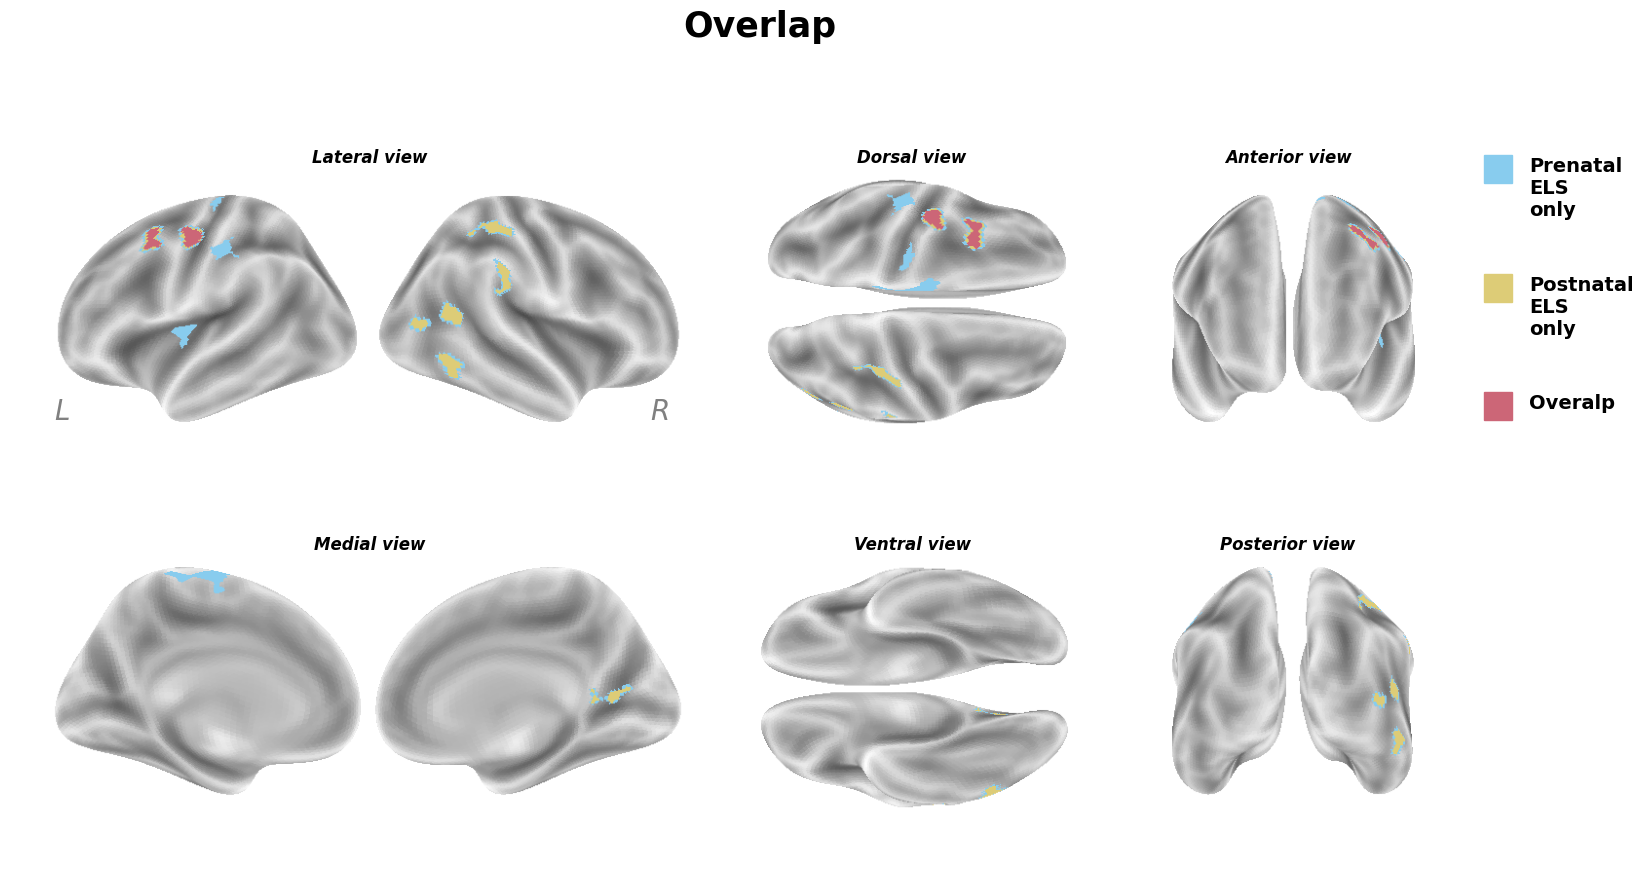

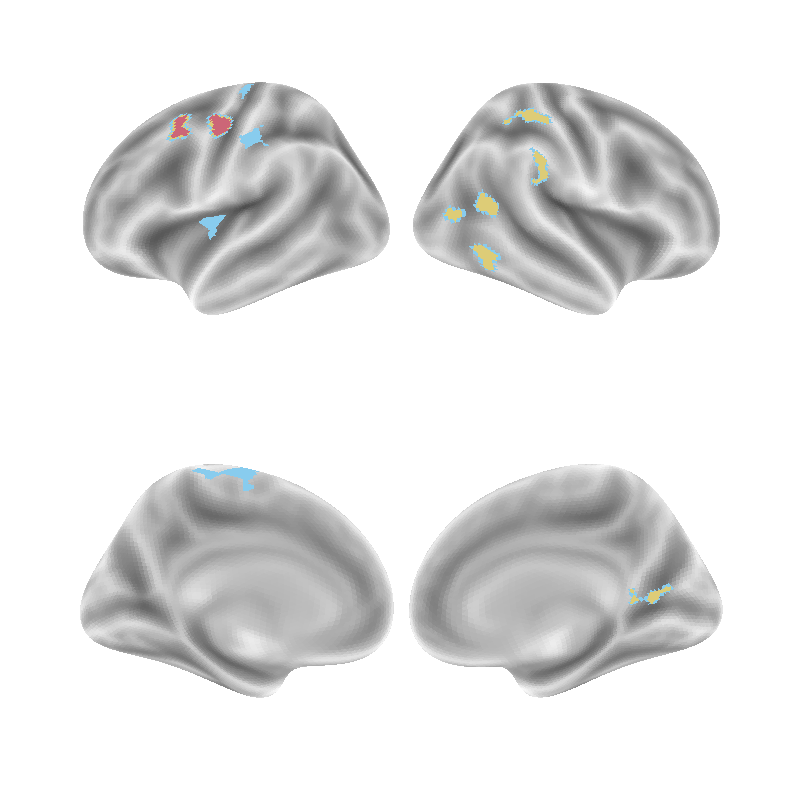

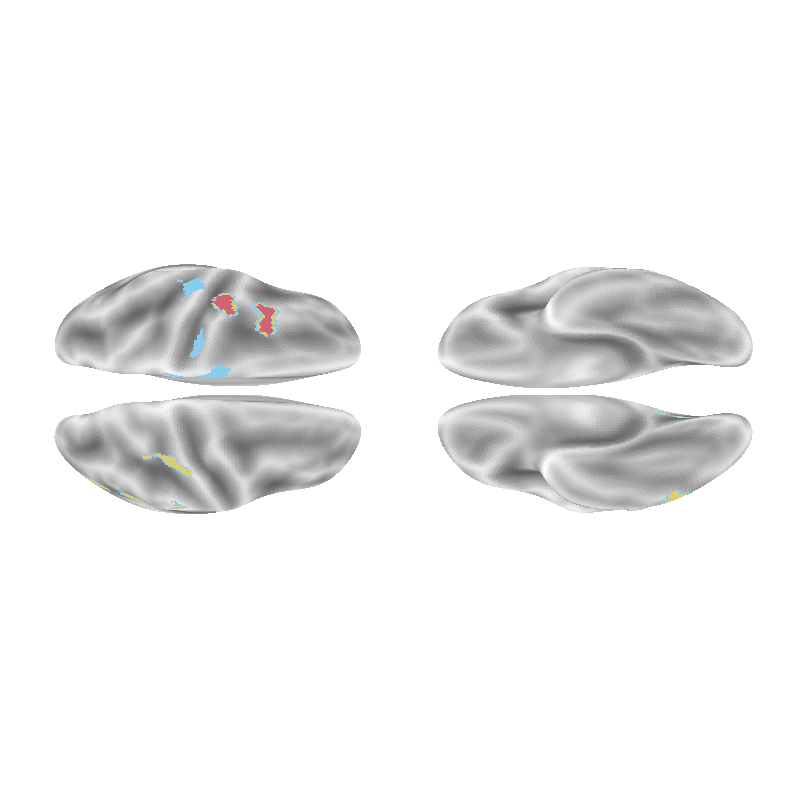

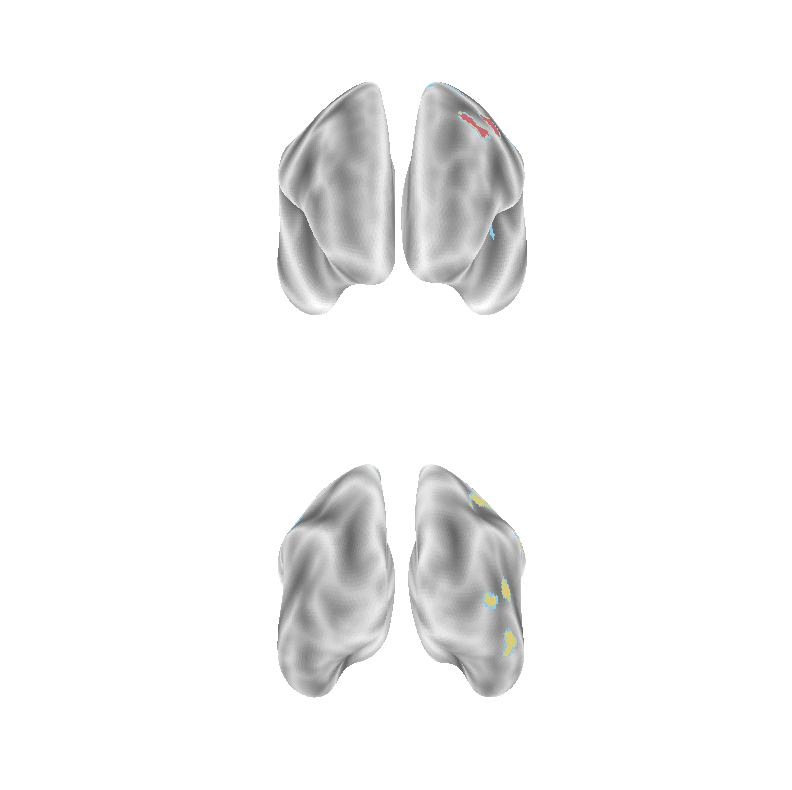

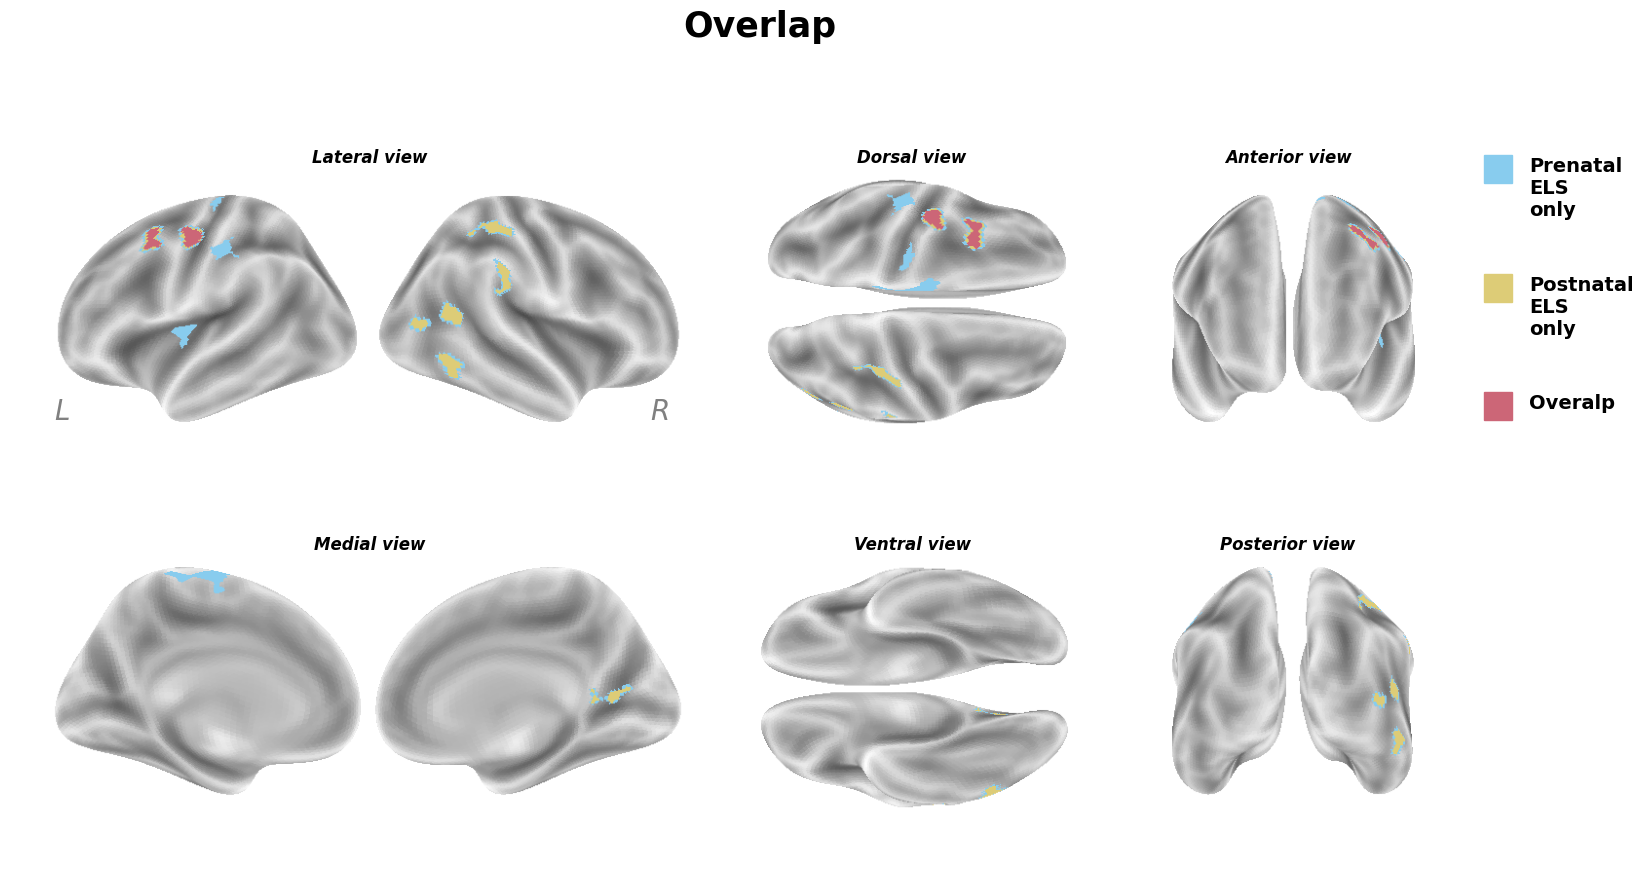

In [11]:
ovlf2 = figure_2(model1='prenatal_stress', term1='prenatal_stress_z',
                 model2='postnatal_stress', term2='postnatal_stress_z')

In [ ]:
## Check regional overlap

# h = 'l'
# mod = 'postnatal_stress'
# df = pd.read_csv(f'{resdir}{h}h.{mod}.w_g.pct/significant_clusters.txt', sep='\t')

# df.loc[df.variable == f'{mod}_z', ]